<a href="https://colab.research.google.com/github/Sanardi/AI-Machine-Learning/blob/master/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install transformers
!pip install pytorch-transformers

     |████████████████████████████████| 778kB 3.3MB/s 
     |████████████████████████████████| 3.0MB 17.6MB/s 
     |████████████████████████████████| 890kB 38.6MB/s 
     |████████████████████████████████| 1.1MB 31.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=194e8971d7d80d6ec8794e0e49d6cc70d352f9e6f7451a672f769da7c4aad55d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 184kB 3.4MB/s 


In [2]:
%pip install torch

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig


In [4]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)


fastai version : 1.0.61
transformers version : 3.0.2


In [ ]:
#this is a span dataset in downloadded from Kaggle:
#df = pd.read_csv("datasets_483_982_spam.csv")

import io
from google.colab import files
uploaded = files.upload()
#df = pd.read_csv("datasets_483_982_spam.csv")
data1 = io.BytesIO(uploaded['train.tsv.zip']) 
train = pd.read_csv(r'train.tsv.zip', sep="\t")

train

In [ ]:
uploaded = files.upload()
#df = pd.read_csv("datasets_483_982_spam.csv")
data2 = io.BytesIO(uploaded['test.tsv.zip']) 
test = pd.read_csv(r'test.tsv.zip', sep="\t")

test

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [ ]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [ ]:
print(model_class)

In [ ]:
model_class.pretrained_model_archive_map.keys()

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
seed_all(seed)

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [ ]:
'''how each models needs their special tokens:

bert:       [CLS] + tokens + [SEP] + padding

roberta:    [CLS] + prefix_space + tokens + [SEP] + padding

distilbert: [CLS] + tokens + [SEP] + padding

xlm:        [CLS] + tokens + [SEP] + padding

xlnet:      padding + tokens + [SEP] + [CLS]'''

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [ ]:
#setting up the data bunch:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
tokens = transformer_tokenizer.tokenize('Ola, estou, Hello it s me, this is crazy, how amazing')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

In [ ]:
databunch = (TextList.from_df(train, cols='Phrase', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'Sentiment')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))



In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

In [ ]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

NameError: ignored

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
#use this to specify the number of classes needed in multi-class problem:

config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

In [ ]:
print(learner.model)

NameError: ignored

In [ ]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

In [ ]:
learner.save('untrain')

In [ ]:


seed_all(seed)
learner.load('untrain');



NameError: ignored

In [ ]:


learner.freeze_to(-1)



NameError: ignored

In [ ]:


learner.summary()



CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [79, 768]            38,603,520 False     
______________________________________________________________________
Embedding            [79, 768]            394,752    False     
______________________________________________________________________
Embedding            [79, 768]            768        False     
______________________________________________________________________
LayerNorm            [79, 768]            1,536      False     
______________________________________________________________________
Dropout              [79, 768]            0          False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
______________________________________________________________________
Linear               [79, 768]            590,592    False     
_______________________________________

In [ ]:


learner.lr_find()



epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 4.37E-04


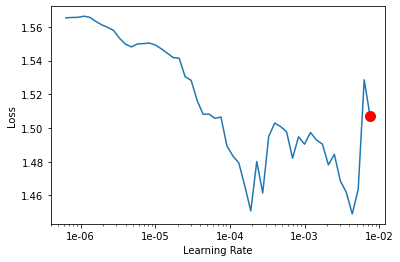

In [ ]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.022306,0.986010,0.598296,0.401704,1:49:31


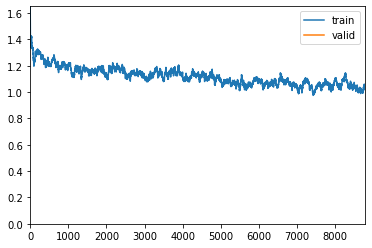

In [ ]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [ ]:


learner.save('first_cycle')



In [ ]:
seed_all(seed)
learner.load('first_cycle');

In [ ]:
learner.freeze_to(-2)

In [ ]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.912999,0.901309,0.636999,0.363001,2:28:19


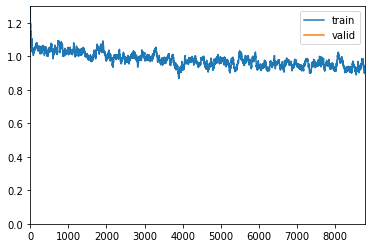

In [ ]:
#slicing to create seperate learning rate for each group

learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('second_cycle')

In [ ]:
seed_all(seed)
learner.load('second_cycle');


In [ ]:
learner.freeze_to(-3)

In [ ]:


learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))



epoch,train_loss,valid_loss,accuracy,error_rate,time


In [ ]:
#this is a span dataset in downloadded from Kaggle:
df = pd.read_csv(r"data/datasets_483_982_spam.csv", encoding="ISO-8859-1", error_bad_lines=False)

df = df.iloc[:, :2]
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:

df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.label.dtypes

dtype('O')

In [ ]:
df["label"] = df["label"].astype(str)#.str.replace("ham", 0)
df["label"] = df["label"].astype(str)#.str.replace("spam", 1)

In [ ]:
df.label.dtypes

dtype('O')

In [ ]:
df["label"] = df["label"].str.replace("ham", 0)
df["label"] = df["label"].str.replace("spam", 1)

TypeError: repl must be a string or callable